# Moller operator applied to excited chain

## 1. Settings
Standart calculation setting

In [15]:
import sys, os
sys.path.insert(0, 'core/')
import one_D_scattering as ods
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import cumtrapz as ct
from wave_pack import convolution, delay
from wave_pack import inverse_pulse as pulse
from wave_pack import efficiency



ods.PAIRS = True

#Control mode Setup
ods.RABI = 0
ods.DC = -4#6#7


#Pulse setup
pdGamma = 0.05#26.7#26.9#2*np.pi
pdShift = +4

#Number of atoms
noa = 150


#Calculation Scheme Setup
ods.RABI_HYP = False
ods.SINGLE_RAMAN = True
ods.RADIATION_MODES_MODEL = 1
ods.VACUUM_DECAY = 1
ods.DDI = 1
ods.EDGE_STABILITY = False
raz = 9600
freq = np.linspace(-1600.5,1600.5, raz)
CSVPATH = 'data/m_arrays/m_pics_13.02.2020/'
if not os.path.exists(CSVPATH):
    os.makedirs(CSVPATH)
#First figure

args = {
    'nat': noa,  # number of atoms
    'nb': 0,  # number of neighbours in raman chanel (for L-atom only)
    's': 'chain',  # Stands for atom positioning : chain, nocorrchain and doublechain
    'dist': 0.,  # sigma for displacement (choose 'chain' for gauss displacement., \lambda/2 units)
    'd': 1.5,  # distance from fiber
    'l0': 2.00/ 2,  # mean distance between atoms (in lambda_m /2 units)
    'deltaP': freq,  # array of freq
    'typ': 'LM',  # L or V for Lambda and V atom resp.
    'ff': 0.3,  # filling factor (for ff_chain only)
    'numexc': 0
}

from scipy.optimize import curve_fit

def extract_time(t, et):
    def _func(x, g, A):
        return A*np.exp(-1*x*g) #np.A*np.exp(-x*g)

    lent = len(t)
    lens = np.int(lent//1.8)
    t = t[lens:lent]
    et = et[lens:lent]

    #plt.plot(t, et)
    #plt.plot(t, et - np.amax(et)*_func(t,1,1))
    #plt.show()

    popt, pcov = curve_fit(_func, t, et/np.amax(et), bounds=(0, 3), method='trf')

    return popt[0]

def smooth(t, et):
    
    def _func(t, g1, g2, g3, A1, A2, A3, rabi):
        return A1*np.exp(-1*g1*t) + A2*np.exp(-1*g2*t) + A3*np.exp(-1*g3*t)
    
    lent = len(t)
    lens = lent//2
    
    t = t[lens:lent]; et = np.real(et[lens:lent])
    
    popt, pcov = curve_fit(_func, t, et/np.amax(et), method='trf')
    
    et = _func(t, *popt) / (popt[3]+popt[4]+popt[5])

    return t, et/et.max()

def smtplot(x,y, *args, **kwargs):
    x1,y1 = smooth(x,y/y.max())
    plt.plot(x1,y1, *args, **kwargs)
    
def decomposeplot(x,y, *args, **kwargs):
    
    def _func(t, g1, g2, A1, A2, rabi, A3):
        return A1*np.exp(-1*g1*t) + A2*np.exp(-1*g2*t)
    
    lent = len(x)
    lens = lent//2
    
    xt = x[lens:lent]; yt = np.real(y[lens:lent])
    
    popt, pcov = curve_fit(_func, xt, yt/np.amax(yt), method='trf')
    
    
    
    x1,y1 = x, np.exp(-1*popt[0]*x)
    x2,y2 = x, np.exp(-1*popt[1]*x)
    plt.plot(x1,y1, *args, **kwargs)
    plt.plot(x2,y2, *args, **kwargs)

def normalplot(t, et, *args, **kwargs):
    def _func(t, g1, A1):
        return A1*np.exp(-1*g1*t)
    
    lent = len(t)
    lena = lent//2
    lenb = lent//2 + lent//20
    
    t1 = t[lena:lenb]; et1 = np.real(et[lena:lenb])
    
    popt, pcov = curve_fit(_func, t1, et1, method='trf')
    
    plt.plot(t, et/_func(0.2, *popt), *args, **kwargs)

def isiinthemiddle(i, noa, notright = False):
    
    if i < noa:
        ni = i
    else:
        ni = (i - noa) % (2 * (noa-1)) // 2
        
    if ni >= noa//3 and ni < noa - noa//3:
        iisright = True
    else:
        iisright = notright
        
    return iisright
    
ods.PAIRS = False
ods.PHASE = np.pi
ods.RANDOM_PHASE = False
ods.RADIATION_MODES_MODEL = True

### 2.1 Decay of Dicke-like state of 100 atoms with certain phase corresponding to the state that appears in Bragg reflection

$$|i\rangle = \sum_{n\in\text{All atoms}} exp(\text{i} \pi n ) \times |g_1, g_2, ..., e_n, ... g_N\rangle$$

In [10]:

ods.RADIATION_MODES_MODEL = 0
ods.VACUUM_DECAY = 0
ods.PAIRS = False
ods.RANDOM_PHASE = False
ods.PHASE = np.pi
ods.EDGE_STABILIY = False
args['s'] = 'chain'
args['nat'] = noa // 3
args['d'] = 1.5
dicke = ods.ensemble(**args)
dicke.generate_ensemble()

dAD = np.zeros_like(dicke.AtomicDecay)

for i in range(len(dicke.AtomicDecay[:, 0])):
     t, dAD[i, :] = convolution(freq, dicke.AtomicDecay[i, :], np.ones_like(freq))
        
dickeDecay = np.dot(np.conj(np.transpose(dAD)), dAD).diagonal()

0.4465742137282849


/home/viacheslav/.anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'sigmaMatrix' does not match runtime version 3.6
  return f(*args, **kwds)


Dimensionality is too small to use CUDA
Memory Error was found. Using iterations:


core/one_D_scattering.py:1353: RuntimeWarning: invalid value encountered in add
  self.fullTransmittance = dm[0, 0, :] + dm[1, 1, :]






Current ensemble calculation time is  5.477240085601807 s


### 2.2 Same as 2.1 but with random phases

In [11]:
ods.RADIATION_MODES_MODEL = 0
ods.VACUUM_DECAY = 0
ods.PAIRS = False
ods.RANDOM_PHASE = True
ods.PHASE = np.pi
args['nat'] = noa//3
args['s'] = 'chain'
resonator_rand = ods.ensemble(**args)
resonator_rand.generate_ensemble()

rADr = np.zeros_like(resonator_rand.AtomicDecay)

for i in range(len(resonator_rand.AtomicDecay[:, 0])):
    t, rADr[i, :] = convolution(freq, resonator_rand.AtomicDecay[i, :], np.ones_like(freq))

rresDecay = np.dot(np.conj(np.transpose(rADr)), rADr).diagonal()

0.4465742137282849
Dimensionality is too small to use CUDA
Memory Error was found. Using iterations:




Current ensemble calculation time is  5.8700010776519775 s


### 2.3 Same as 2.1 but with 100 atoms in the ground state to the left to the excited atoms

In [ ]:
ods.RADIATION_MODES_MODEL = 0
ods.VACUUM_DECAY = 0
ods.PAIRS = True
ods.RANDOM_PHASE = False
ods.PHASE = np.pi
args['nat'] = 2* (noa // 3)
args['s'] = 'side-mirror'
sidem = ods.ensemble(**args)
args['d'] = 1.5
sidem.generate_ensemble()

smD = np.zeros_like(sidem.AtomicDecay)

for i in range(len(sidem.AtomicDecay[:, 0])):
    _, smD[i, :] = convolution(freq, sidem.AtomicDecay[i, :], np.ones_like(freq))
    
sidemDecay = np.dot(np.conj(np.transpose(smD)), smD).diagonal()

### 2.4 Same as 2.3 but with 100 atoms in the ground state to the right to the excited atoms

In [11]:
ods.RADIATION_MODES_MODEL = 0
ods.VACUUM_DECAY = 0
ods.PAIRS = False
ods.RANDOM_PHASE = False
ods.PHASE = np.pi
ods.EDGE_STABILIY = False
args['nat'] = noa
args['s'] = 'resonator'
args['d'] = 1.5
ods.LMDA = 0*1.
resonator = ods.ensemble(**args)
resonator.generate_ensemble()

rAD = np.zeros_like(resonator.AtomicDecay)

for i in range(len(resonator.AtomicDecay[:, 0])):
        
    if isiinthemiddle(i, noa, True):
        _, rAD[i, :] = convolution(freq, resonator.AtomicDecay[i, :], np.ones_like(freq))
    

    
resDecay = np.dot(np.conj(np.transpose(rAD)), rAD).diagonal()

rAD = np.zeros_like(resonator.AtomicDecay)

for i in range(len(resonator.AtomicDecay[:, 0])):
        
    if isiinthemiddle(i, noa, False):
        _, rAD[i, :] = convolution(freq, resonator.AtomicDecay[i, :], np.ones_like(freq))
    
shiftresDecay = np.dot(np.conj(np.transpose(rAD)), rAD).diagonal()


ddRight_in = np.zeros_like(resonator.AtomicDecay[:,0])
ddRight_full = np.zeros_like(resonator.AtomicDecay[:,0])

for i in range(noa):
    if isiinthemiddle(i, noa, False):
        ddRight_in[i] = (-1)**i
            
    ddRight_full[i] = (-1)**i
        
t, blochIn = convolution(freq, np.dot(ddRight_in, resonator.AtomicDecay), np.ones_like(freq))
inDecay = abs(blochIn)**2

t, blochFull = convolution(freq, np.dot(ddRight_full, resonator.AtomicDecay), np.ones_like(freq))
fullDecay = abs(blochFull)**2

0.4465742137282849
Dimensionality is too small to use CUDA
Memory Error was found. Using iterations:


core/one_D_scattering.py:1355: RuntimeWarning: invalid value encountered in add
  self.fullReflection = dm[2, 2, :] + dm[3, 3, :]






Current ensemble calculation time is  27.444905519485474 s


In [18]:
ods.RADIATION_MODES_MODEL = 0
ods.VACUUM_DECAY = 0
ods.PAIRS = True
ods.RANDOM_PHASE = False
ods.PHASE = np.pi
ods.EDGE_STABILIY = False
ods.LMDA = 1.
args['nat'] = noa
args['s'] = 'resonator'
args['d'] = 1.5
resonator = ods.ensemble(**args)
resonator.generate_ensemble()

rAD = np.zeros_like(resonator.AtomicDecay)

for i in range(len(resonator.AtomicDecay[:, 0])):
        
    if isiinthemiddle(i, noa, True):
        _, rAD[i, :] = convolution(freq, resonator.AtomicDecay[i, :], np.ones_like(freq))
    

    
extresDecay = np.dot(np.conj(np.transpose(rAD)), rAD).diagonal()

rAD = np.zeros_like(resonator.AtomicDecay)
for i in range(len(resonator.AtomicDecay[:, 0])):
        
    if isiinthemiddle(i, noa, False):
        _, rAD[i, :] = convolution(freq, resonator.AtomicDecay[i, :], np.ones_like(freq))
    

    
extshiftresDecay = np.dot(np.conj(np.transpose(rAD)), rAD).diagonal()

0.4465742137282849
56%[K100%[K1.0


Current ensemble calculation time is  268.4350597858429 s


### 2.5 Same as 2.4 but with slightly shifted phases $\approx 5\%$

In [136]:
ods.RADIATION_MODES_MODEL = 0
ods.VACUUM_DECAY = 0
ods.PAIRS = True
ods.RANDOM_PHASE = False
ods.PHASE = np.pi*1.05
args['nat'] = noa
args['s'] = 'resonator'
args['d'] = 1.5
resonator_deph = ods.ensemble(**args)
resonator_deph.generate_ensemble()

rADd = np.zeros_like(resonator_deph.AtomicDecay)

for i in range(len(resonator_deph.AtomicDecay[:, 0])):
    _, rADd[i, :] = convolution(freq, resonator_deph.AtomicDecay[i, :], np.ones_like(freq))
    
dresDecay = np.dot(np.conj(np.transpose(rADd)), rADd).diagonal()

0.4465742137282849


KeyboardInterrupt: 

### 2.6 Same as 2.3 but with 800 atoms in the ground state

In [ ]:
ods.RANDOM_PHASE = False
args['nat'] = noa*3
ods.PHASE = np.pi
args['d'] = 1.5
args['s'] = 'big-side-mirror'
bigSidem = ods.ensemble(**args)
bigSidem.generate_ensemble()

bigSad = np.zeros_like(bigSidem.AtomicDecay)

for i in range(3*(noa//3)):
    _, bigSad[i, :] = convolution(freq, bigSidem.AtomicDecay[i, :], np.ones_like(freq))
    
bigSidemDecay = np.dot(np.conj(np.transpose(bigSad)), bigSad).diagonal()

### 2.7 Same as 2.4 but with 400 atoms in ground state on both sides

In [35]:
ods.RANDOM_PHASE = False
args['nat'] = noa*3
ods.PHASE = np.pi
args['d'] = 1.5
args['s'] = 'big-resonator'
bigResonator = ods.ensemble(**args)
bigResonator.generate_ensemble()

bigRad = np.zeros_like(bigResonator.AtomicDecay)

for i in range(3*noa):
    _, bigRad[i, :] = convolution(freq, bigResonator.AtomicDecay[i, :], np.ones_like(freq))
    
bigResDecay = np.conj(np.transpose(bigRad))[:, 4] * bigRad[4, :]

0.4465742137282849
Dimensionality is too small to use CUDA
Memory Error was found. Using iterations:




Current ensemble calculation time is  3.2534656524658203 s


## 3 Plotting

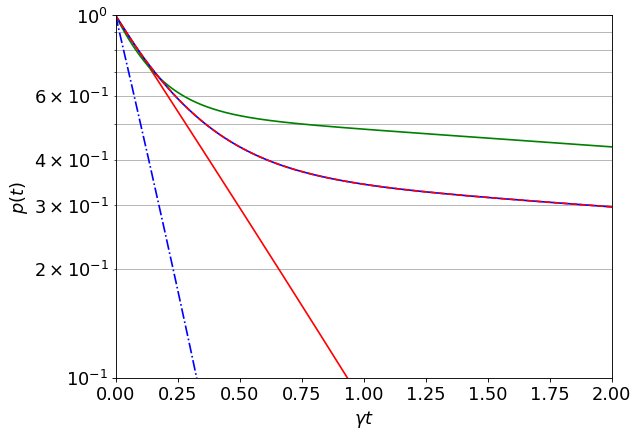

In [29]:
plt.rcParams.update({'font.size': 16})
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.grid(True, axis='y', which='both')
plt.xlim([0,2])
plt.ylim([0.1, 1.])
plt.yscale('log')
dcay = np.exp(-t)
smtplot(t, (dickeDecay/dickeDecay.max()), 'r')
smtplot(t, resDecay/resDecay.max(), 'g')
smtplot(t, shiftresDecay/shiftresDecay.max(), 'b-')
smtplot(t, inDecay/inDecay.max(), 'r--')
smtplot(t, fullDecay/fullDecay.max(), 'b-.')
#plt.plot(t, extresDecay/resDecay.max()/0.8, 'g')
#plt.plot(t, extshiftresDecay/shiftresDecay.max()/0.8/0.88, 'g--')
#smtplot(t, dresDecay/dresDecay.max(), 'm-.')
#smtplot(t, rresDecay/rresDecay.max(), 'c--')
#smtplot(t, dcay, 'k--')
#plt.plot(t, sidemDecay/sidemDecay.max(), 'b')
#smtplot(t, bigResDecay, 'r--')
#smtplot(t, bigSidemDecay/bigSidemDecay.max(), 'r-.')
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$p(t)$')
plt.savefig(CSVPATH + 'ms_stableedg.svg')
plt.show()

#shiftresDecay = resDecay.copy()

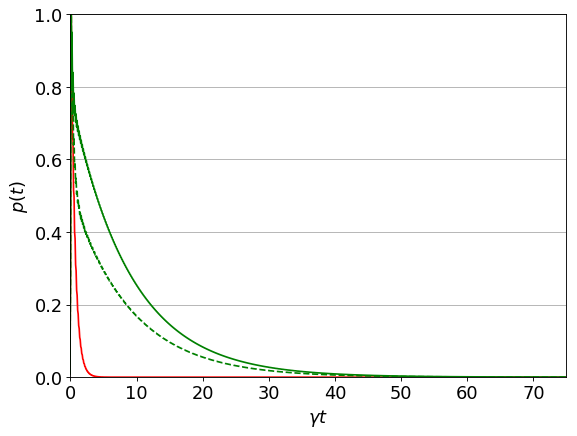

In [39]:
plt.rcParams.update({'font.size': 16})
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.grid(True, axis='y', which='both')
plt.xlim([00,75])
plt.ylim([0.001, 1.0])
#plt.yscale('log')
dcay = np.exp(-t)
plt.plot(t, (dickeDecay/dickeDecay.max())/0.8, 'r')
plt.plot(t, resDecay/resDecay.max()/0.8, 'g')
plt.plot(t, shiftresDecay/shiftresDecay.max()/0.8, 'g--')
#smtplot(t, dresDecay/dresDecay.max(), 'm-.')
#smtplot(t, rresDecay/rresDecay.max(), 'c--')
#plt.plot(t, dcay, 'k--')
#plt.plot(t, sidemDecay/sidemDecay.max(), 'b')
#smtplot(t, bigResDecay, 'r--')
#smtplot(t, bigSidemDecay/bigSidemDecay.max(), 'r-.')
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$p(t)$')
plt.savefig(CSVPATH + 'ms_stableedg.svg')
plt.show()


## 4. Saving

In [ ]:
dcay = np.exp(-t)
ts, _ddecay = smooth(t, np.real(dickeDecay))
lines = np.empty((len(ts), 7), dtype=np.float32)


    
def toMathematica(fname, *argv):
    toCsv = np.column_stack(argv)
    np.savetxt(CSVPATH + fname + '.csv', toCsv, delimiter=',', fmt='%1.8f')


lines[:, 0], lines[:, 1] = smooth(t, np.real(dickeDecay))
_, lines[:, 2] = smooth(t, resDecay)
_, lines[:, 3] = smooth(t, dresDecay/dresDecay.max())
_, lines[:, 4] = smooth(t, rresDecay/rresDecay.max())
_, lines[:, 5] = smooth(t, dcay)
_, lines[:, 6] = smooth(t, sidemDecay)
#_, lines[:, 7] = smooth(t, bigResDecay)
#_, lines[:, 8] = smooth(t, bigSidemDecay/bigSidemDecay.max())

toMathematica('comparison', lines)

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.grid(True, axis='y', which='both')
plt.xlim([0,3])
plt.ylim([0.05, 1])
plt.yscale('log')
dcay = np.exp(-t)
smtplot(t, dickeDecay, 'r')
smtplot(t, resDecay, 'g')
#smtplot(t, dresDecay/dresDecay.max(), 'm-.')
#smtplot(t, rresDecay/rresDecay.max(), 'c--')
smtplot(t, dcay, 'k--')
smtplot(t, sidemDecay, 'b')
#smtplot(t, bigResDecay, 'r--')
#smtplot(t, bigSidemDecay/bigSidemDecay.max(), 'r-.')
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$p(t)$')
plt.show()

In [ ]:
distances = np.linspace(1.1, 3.5, 10)
gammas_resonator = np.zeros_like(distances)
gammas_dicke = np.zeros_like(distances)

for j,dist in enumerate(distances):
    ods.RANDOM_PHASE = False
    args['nat'] = noa
    args['s'] = 'resonator'
    args['d'] = dist
    res = ods.ensemble(**args)
    res.generate_ensemble()

    rAD = np.zeros_like(res.AtomicDecay)

    for i in range(noa):
        t, rAD[i, :] = convolution(freq, res.AtomicDecay[i, :], np.ones_like(freq))
    
    resDecay = np.dot(np.conj(np.transpose(rAD)), rAD).diagonal()
    gammas_resonator[j] = extract_time(t, np.real(resDecay))
    
    ods.RANDOM_PHASE = False
    args['s'] = 'chain'
    args['nat'] = noa // 3
    args['d'] = dist
    dicke = ods.ensemble(**args)
    dicke.generate_ensemble()

    dAD = np.zeros_like(dicke.AtomicDecay)

    for i in range(noa//3):
         t, dAD[i, :] = convolution(freq, dicke.AtomicDecay[i, :], np.ones_like(freq))
        
    dickeDecay = np.dot(np.conj(np.transpose(dAD)), dAD).diagonal()
    
    gammas_dicke[j] = extract_time(t, np.real(dickeDecay))
    
plt.plot(distances, gammas_resonator, 'ro')
plt.plot(distances, gammas_dicke)
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel(r'$\rho / a$')
plt.ylabel(r'$\Gamma_{{eff}} / \gamma$')
plt.yscale('log')
plt.plot(distances, gammas_resonator, 'r')
plt.plot(distances, gammas_dicke, 'b')
plt.show()

In [ ]:
ods.PAIRS = False
ods.PHASE = np.pi
ods.RANDOM_PHASE = False


args['nat'] = noa
args['s'] = 'resonator'

nums = 100
lmda = np.linspace(0, 2*np.pi, nums)
ets = np.empty((raz, nums))
dtime = np.zeros_like(lmda)
for i, _ in enumerate(lmda):
    ods.PHASE = lmda[i]
    resonator = ods.ensemble(**args)
    resonator.generate_ensemble()
    AD = np.zeros_like(resonator.AtomicDecay)
    for j in range(noa):
        t, AD[j, :] = convolution(freq, resonator.AtomicDecay[j, :], np.ones_like(freq))
    et = np.dot(np.conj(np.transpose(AD)), AD).diagonal()
    dtime[i] = extract_time(t, et)
    ets[:,i] = et

In [ ]:
for i in range(nums):
    pass
    #plt.plot(t, ets[:,i]/np.amax(ets[:,i]), 'b-.')
plt.plot(t, ets[:, 50]/ets[:, 50].max(), 'g--')

plt.yscale('log')
plt.xlim(0,2)
plt.ylim(0.1,1)
plt.show()

In [ ]:
plt.plot(lmda[40:60], dtime[40:60])
plt.show()

In [ ]:
lmda = np.linspace(0, 2*np.pi, 100)
lmda[51]

In [ ]:
resDecay[raz//2]

In [ ]:
t

In [ ]:
t[len(t)//2]

In [16]:
7*24

168

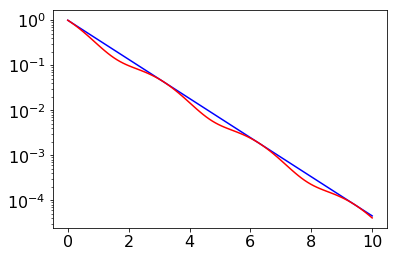

In [91]:
def multiexp(t, g1, rabi, g2, eps):
    return (np.exp(-g1*t) + eps*np.cos(rabi*t)*np.exp(-g2*t)) / (1+eps)

ts = np.linspace(0, 10, 100)
plt.yscale('log')
plt.plot(ts, np.exp(-t), 'b')
plt.plot(ts, multiexp(t, 1, 2, 1, 0.2),'r')
plt.show()

In [4]:
-1**3

-1

150

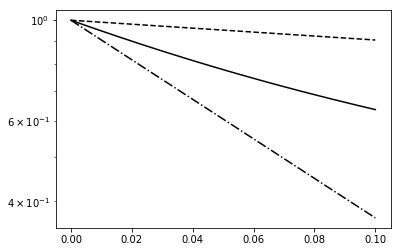

In [8]:
xt = np.linspace(0,.1, 1000)
yt = 0.5 * np.exp(-10*xt) + 0.5*np.exp(-1*xt)
zt = np.exp(-1*xt)
mt = np.exp(-10*xt)

plt.plot(xt, yt, 'k-')
plt.plot(xt, zt, 'k--')
plt.plot(xt, mt, 'k-.')

plt.yscale('log')
plt.show()